# Task 1.

howtorun: download data using `download_data.sh` and run those cells

In [ ]:
import torch
from torch import nn

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm

from unet import Unet

from dataset import get_train_data


torch.manual_seed(42)

## Training in full precision

In [ ]:
def train_epoch(
    train_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> None:
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(f"Loss: {round(loss.item(), 4)} " f"Accuracy: {round(accuracy.item() * 100, 4)}")


def train():
    torch.manual_seed(42)

    device = torch.device("cuda:0")
    model = Unet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loader = get_train_data()

    num_epochs = 5
    for epoch in range(0, num_epochs):
        train_epoch(train_loader, model, criterion, optimizer, device=device)


In [ ]:
train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Training in mixed precision without torch loss scaler

In [ ]:
def train_epoch(
    train_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> None:
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(f"Loss: {round(loss.item(), 4)} " f"Accuracy: {round(accuracy.item() * 100, 4)}")


def train():
    torch.manual_seed(42)

    device = torch.device("cuda:0")
    model = Unet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loader = get_train_data()

    num_epochs = 5
    for epoch in range(0, num_epochs):
        train_epoch(train_loader, model, criterion, optimizer, device=device)


In [ ]:
train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Training in mixed precision with pytorch scaler

In [ ]:
def train_epoch(
    train_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    scaler,
) -> None:
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(f"Loss: {round(loss.item(), 4)} " f"Accuracy: {round(accuracy.item() * 100, 4)}")


def train():
    torch.manual_seed(42)

    device = torch.device("cuda:0")
    model = Unet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()

    train_loader = get_train_data()

    num_epochs = 5
    for epoch in range(0, num_epochs):
        train_epoch(train_loader, model, criterion, optimizer, device=device, scaler=scaler)


In [ ]:
train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Conclusions:
1. Mixed precision training without grad scaling is bad
2. Mixed precision training with grad scaling converges better than full precision training (in that specific case)

## Static loss scaling

In [ ]:
def train_epoch(
    train_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> None:
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        # TODO: your code for loss scaling here
        scale_factor = 128
        loss *= scale_factor
        loss.backward()
        for name, parameter in model.named_parameters():
            parameter.grad /= scale_factor
        optimizer.step()
        optimizer.zero_grad()
        loss /= scale_factor
        #

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(f"Loss: {round(loss.item(), 4)} " f"Accuracy: {round(accuracy.item() * 100, 4)}")


def train():
    torch.manual_seed(42)

    device = torch.device("cuda:0")
    model = Unet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loader = get_train_data()

    num_epochs = 5
    for epoch in range(0, num_epochs):
        train_epoch(train_loader, model, criterion, optimizer, device=device)


train()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Dynamic loss scaling

In [ ]:
class CustomGradScaler:
    '''Simple gradient scaler. Implements exponential-backoff strategy for
    updating the scale factor, like in the original PyTorch GradientScaler'''
    def __init__(self, init_scale, growth_factor, backoff_factor, growth_interval):
        self.current_scale = init_scale
        self.growth_factor = growth_factor
        self.backoff_factor = backoff_factor
        self.growth_interval = growth_interval

        self._performed_update_last_step = False
        self._steps_with_update = 0

    def scale(self, loss):
        return loss * self.current_scale

    def step(self, optimizer):
        if not self._should_update_params(optimizer):
            optimizer.zero_grad()
            self._performed_update_last_step = False
            self._steps_with_update = 0
            return

        for group in optimizer.param_groups:
            for param in group['params']:
                param.grad /= self.current_scale

        optimizer.step()
        optimizer.zero_grad()

        self._steps_with_update += 1
        self._performed_update_last_step = True

    def _should_update_params(self, optimizer):
        for group in optimizer.param_groups:
            for param in group['params']:
                if torch.any(param.grad.isnan()) or torch.any(param.grad.isinf()):
                    return False

        return True

    def update(self):
        if not self._performed_update_last_step:
            self.current_scale *= self.backoff_factor
        elif self._steps_with_update >= self.growth_interval:
            self.current_scale *= self.growth_factor


def train_epoch(
    train_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    scaler,
) -> None:
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(f"Loss: {round(loss.item(), 4)} " f"Accuracy: {round(accuracy.item() * 100, 4)}")


def train():
    torch.manual_seed(42)

    device = torch.device("cuda:0")
    model = Unet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loader = get_train_data()
    scaler = CustomGradScaler(init_scale=32, growth_factor=2, backoff_factor=0.5, growth_interval=20)

    num_epochs = 5
    for epoch in range(0, num_epochs):
        train_epoch(train_loader, model, criterion, optimizer, device=device, scaler=scaler)


train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

# Task 2.



howtorun: download data using `download_data.sh` and run `run_epoch.py`

| | BigBrain | UltraBigBrain | UltraDuperBigBrain_1 | UltraDuperBigBrain_5 | UltraDuperBigBrain_10 | UltraDuperBigBrain_20 | UltraDuperBigBrain_50 | UltraDuperBigBrain_640
|----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| min time | 0.338 | 0.050 | 0.002 | 0.002 | 0.002 | 0.002 | 0.002 | 0.004 |
| max time | 0.456 | 0.363 | 0.180 | 0.222 | 0.240 | 0.340 | 0.204 | 0.430 |
| mean time | 0.353 | 0.181 | 0.043 | 0.042 | 0.044  | 0.052 | 0.047 | 0.114 |
| median time | 0.352 | 0.175 | 0.035 | 0.032 | 0.035 | 0.039 | 0.040 | 0.107 |

# Task 3.

howtorun: run `run_epoch.py`

1. Profiling.


  - Embedding Layer: ~0.723 ms. This layer contains only reshape and linear operations; thus, the most intense procedures are aten::reshape and aten::linear. Additionally, the profiler did not recognize some significant part of this layer's activity, leading me to believe that there is overhead due to slicing images into patches.
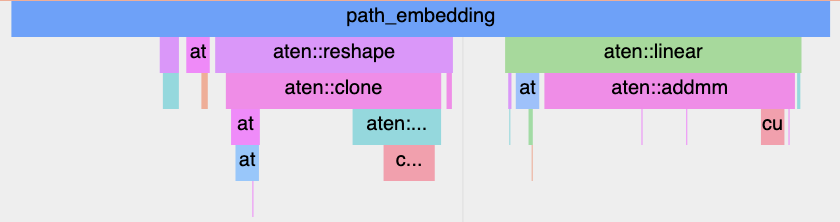



  - Attention Layer: ~0.5 ms for self-attention and ~0.344 ms for the feedforward part. The most intense operations in self-attention are aten::linear and aten::matmul, which is to be expected since these are the most common operations in this layer. For the feedforward layer, the most intense operations are LayerNorm and Linear, with two linear layers consuming only ~25% more than a single LayerNorm. Since self-attention involves more processes, it is slower compared to the feedforward layer.
  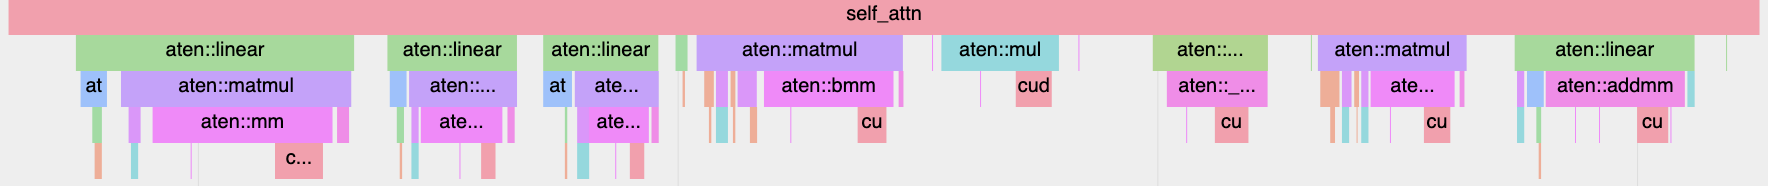
  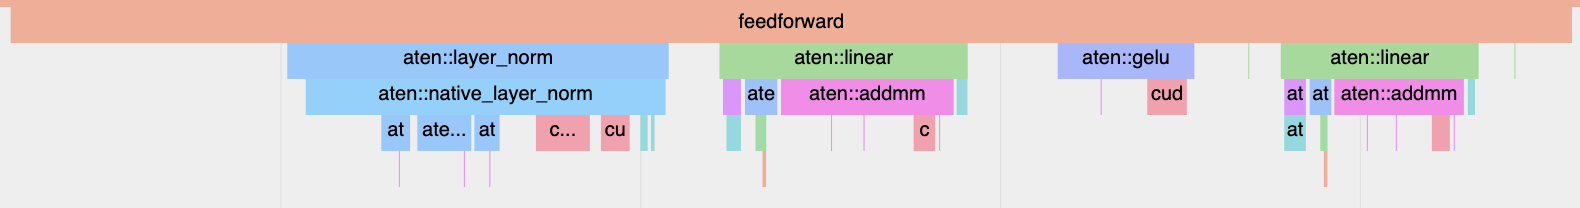

  - Activations: ~0.022 ms for SoftMax and ~0.023 ms for GeLU.
  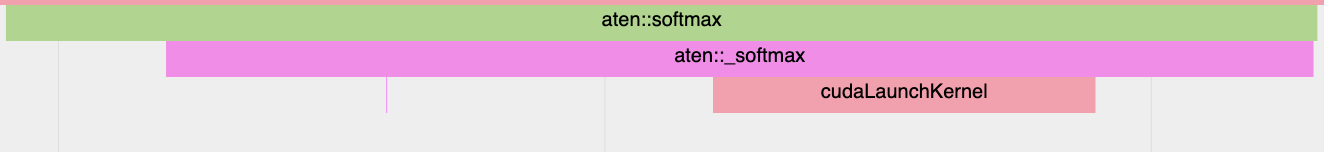
  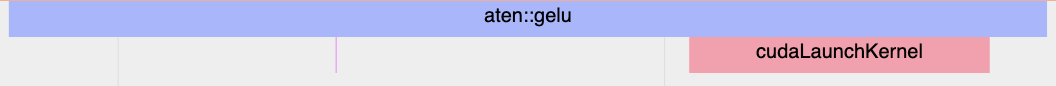


  - Backward pass: The backward pass takes approximately 36.01 ms, while the forward pass takes about 13.48 ms, making the backward pass roughly 2.67 times slower than the forward pass.
  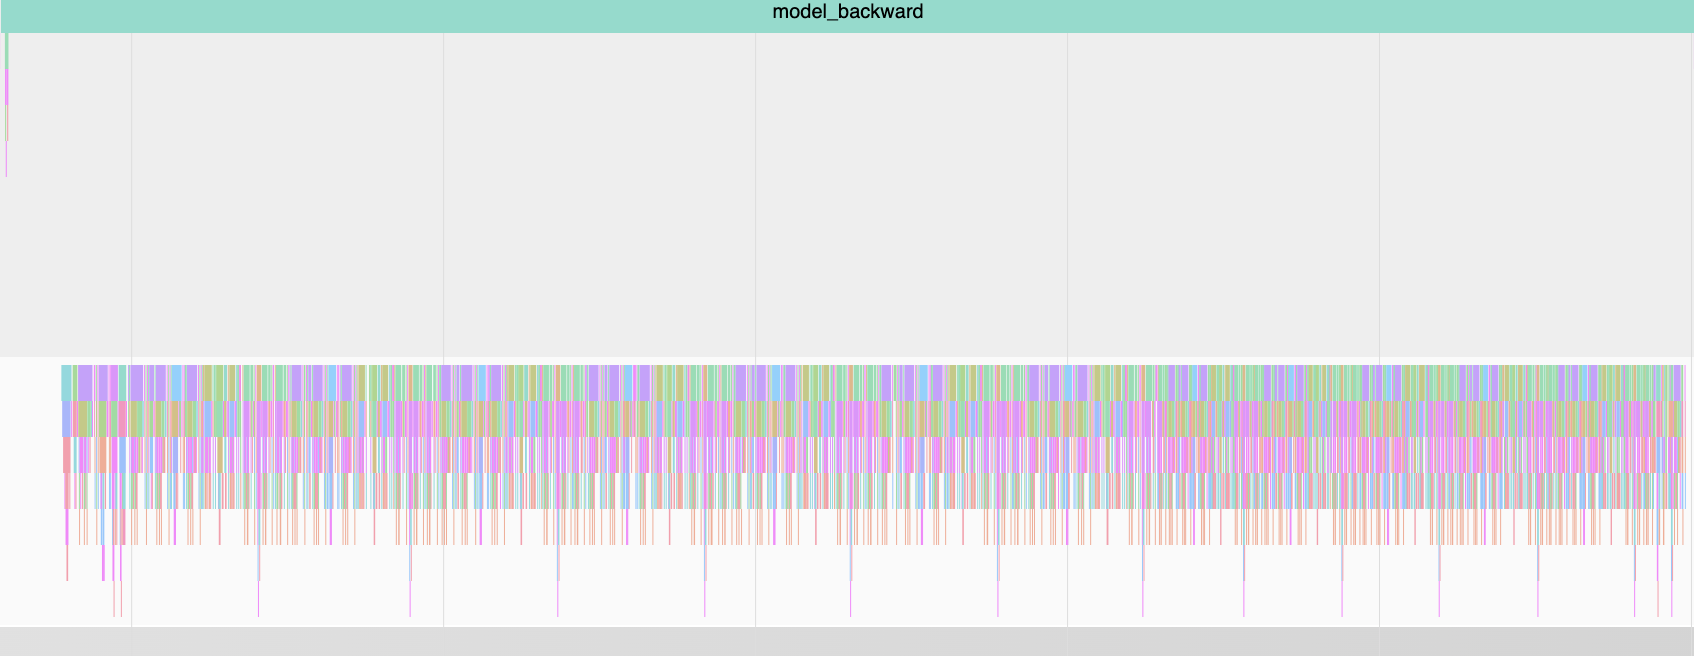
  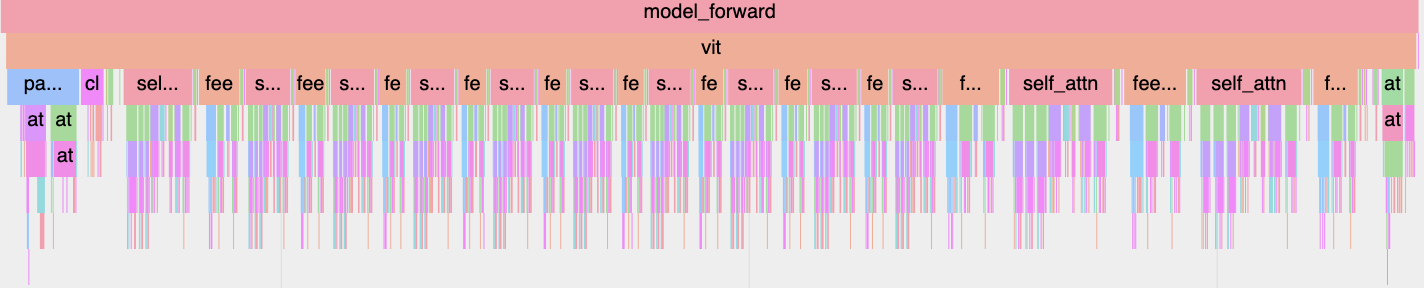

2. Improvements
- Replaced the original Pillow with Pillow-SIMD, significantly improving image reading speed.
- Set `pin_memory=True` in the DataLoader, thereby enhancing host-to-device transfer speed.
- Configured `num_workers=4` in the DataLoader to improve batch prefetching efficiency.
- Moved the calculation of metrics to the end of the training loop and onto the GPU, allowing for asynchronous execution and eliminating the need for device-to-host transfer.
- Consolidated three Linear layers for q, k, and v into a single layer, incorporating three times more parameters.

As a result, this reduced the training loop time consumption from approximately 38 seconds per iteration to roughly 5 seconds per iteration.